https://www.kaggle.com/rautaki0127/pokemon-data-science-challenge/notebook

ポケモンの勝敗予測の問題をやってみる。

提供されるCSV

- pokemon.csv
 - ポケモンの属性表
- combats.csv
 - 過去のポケモンの勝敗
- tests.csv
 - 勝敗予測するポケモンの組み合わせ

In [16]:
import pandas as pd
combats = pd.read_csv('./input/combats.csv')
combats.head(3)

,First_pokemon,Second_pokemon,Winner
0,266,298,298
1,702,701,701
2,191,668,668


In [17]:
pokemon = pd.read_csv('./input/pokemon.csv')
pokemon_266_298 = pokemon[pokemon['#'].isin([266, 298])]
pokemon_266_298

,#,Name,Type 1,Type 2,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary
265,266,Larvitar,Rock,Ground,50,64,50,45,50,41,2,False
297,298,Nuzleaf,Grass,Dark,70,70,40,60,40,60,3,False


In [19]:
import pandas as pd
tests = pd.read_csv('./input/tests.csv')
tests.head(3)

,First_pokemon,Second_pokemon
0,129,117
1,660,211
2,706,115


In [20]:
names_dict = dict(zip(pokemon['#'], pokemon['Name']))
cols = ["First_pokemon","Second_pokemon","Winner"]
combats_name = combats[cols].replace(names_dict)
combats_name.head(3)

,First_pokemon,Second_pokemon,Winner
0,Larvitar,Nuzleaf,Nuzleaf
1,Virizion,Terrakion,Terrakion
2,Togetic,Beheeyem,Beheeyem


最初はざっくりした傾向を見るところから始める。

ポケモンの属性値を足し合わせた数値でヒストグラムを作ってみる。
- 合計のポケモンの数は８００
- 300と500の周辺に分布している

count    800.00000
mean     435.10250
std      119.96304
min      180.00000
25%      330.00000
50%      450.00000
75%      515.00000
max      780.00000
Name: stats_sum, dtype: float64


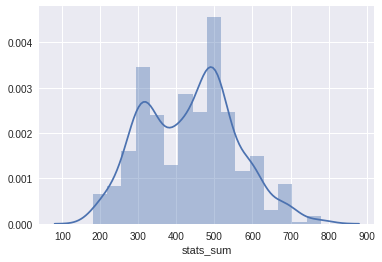

In [21]:
pokemon["stats_sum"] = pokemon["HP"] + pokemon["Attack"] + pokemon["Defense"] + pokemon["Sp. Atk"] + pokemon["Sp. Def"] + pokemon["Speed"]
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
print(pokemon["stats_sum"].describe())
sns.distplot(pokemon["stats_sum"])
plt.show()

勝敗の履歴の分析
- 50000バトルの情報がある
- ？ここもうちょっとみないとわからない。あるポケモンが勝つ比率？

count    50000.000000
mean       136.551440
std        101.221212
min          0.000000
25%         54.000000
50%        118.000000
75%        200.000000
max        590.000000
dtype: float64


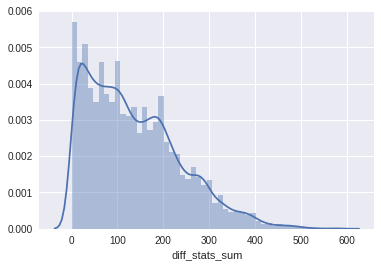

In [22]:
stats_sum_dict = dict(zip(pokemon['#'], pokemon['stats_sum']))
combats_stats_sum = combats[cols].replace(stats_sum_dict)
diff_stats_sum = abs(combats_stats_sum["First_pokemon"]-combats_stats_sum["Second_pokemon"])
print(diff_stats_sum.describe())
sns.distplot(diff_stats_sum)
plt.xlabel("diff_stats_sum")
plt.show()

ポケモンの勝率は一様ではないので、何らかの因子によって勝ちやすいポケモンがいることになる
まず、基本性能がいいポケモンが勝つ可能性を検討する

結果としてはより基本性能がいいポケモンがより勝率が高いというもの

count    50000.000000
mean        79.776320
std        150.093351
min       -562.000000
25%        -20.000000
50%         80.000000
75%        186.000000
max        590.000000
dtype: float64


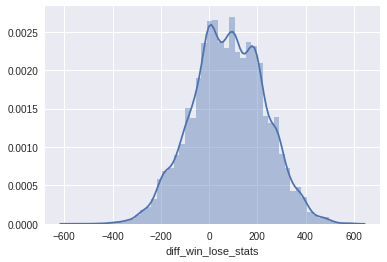

In [23]:
combats_stats_sum["Loser"] = combats_stats_sum.apply(lambda x: x["First_pokemon"] if x["First_pokemon"] !=  x["Winner"] else x["Second_pokemon"], axis = 1)
diff_win_lose_stats = combats_stats_sum["Winner"] - combats_stats_sum["Loser"]
print(diff_win_lose_stats.describe())
sns.distplot(diff_win_lose_stats)
plt.xlabel("diff_win_lose_stats")
plt.show()

より基本性能の高いポケモンが勝つという仮説に対して、より基本性能が低いポケモンが勝ったらケースを確認してみる
- 5000を超えるケースで、100ポイント以上基本性能が下回るポケモンが勝利している

In [24]:
stats_sum_dict_re = dict(zip(pokemon['stats_sum'], pokemon['#']))
combats_stats_sum["diff"] = diff_win_lose_stats
surpassing_stats_sum = combats_stats_sum[combats_stats_sum["diff"] < -100]
print ("Surpassing one's superiors Battle number : " + str(len(surpassing_stats_sum)))
surpassing_id = surpassing_stats_sum[cols].replace(stats_sum_dict_re)
surpassing_name = surpassing_id[cols].replace(names_dict)
surpassing_name.join(combats_stats_sum["diff"]).head(8)

Surpassing one's superiors Battle number : 5716


,First_pokemon,Second_pokemon,Winner,diff
5,Joltik,Aegislash Shield Forme,Joltik,-201
36,Pancham,Whismur,Whismur,-108
37,Clauncher,Dusclops,Clauncher,-125
42,Goomy,Bouffalant,Goomy,-190
51,Mega Rayquaza,Aegislash Shield Forme,Aegislash Shield Forme,-260
158,Bouffalant,Vullaby,Vullaby,-120
168,Keldeo Resolute Forme,Arbok,Arbok,-142
174,Gothorita,Volcanion,Gothorita,-210


特に代表的な、基本性能が下のポケモンが勝つ組み合わせ

In [25]:
surpassing_name.join(combats_stats_sum["diff"]).sort_values(by="diff").head(4)

,First_pokemon,Second_pokemon,Winner,diff
5861,Mega Rayquaza,Cleffa,Cleffa,-562
2480,Mega Rayquaza,Cleffa,Cleffa,-562
41824,Shedinja,Mega Rayquaza,Shedinja,-544
3506,Mega Rayquaza,Inkay,Inkay,-492


より弱いポケモンが勝つ理由について仮説を立てる
- 先攻が勝っているのではないか
- ポケモンの属性によって勝っているのではないか

※ここでドメインの知識があればたくさん精度の高い仮説が出せるんだろうなって感じがする。
いい仮説がたくさん出せればうまくいけば機械学習の工程がほぼ検証作業にできるわけで圧倒的に効率がいい

まず先攻の勝率と負け率を比べてみる。
結果あまり差はみられない

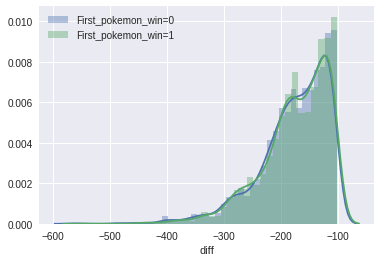

In [26]:
combats_stats_sum["First_Win"] =  combats_stats_sum.apply(lambda x: 1 if x["First_pokemon"] ==  x["Winner"] else 0, axis = 1)
surpassing_stats_sum = combats_stats_sum[combats_stats_sum["diff"] < -100]
sns.distplot(surpassing_stats_sum[surpassing_stats_sum["First_Win"]==0]["diff"], label="First_pokemon_win=0")
sns.distplot(surpassing_stats_sum[surpassing_stats_sum["First_Win"]==1]["diff"], label="First_pokemon_win=1")
plt.legend()
plt.show()